# Time series forecasting

## Setup

In [44]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Daten laden

Daten aus Excel in ein pandas Dataframe laden und Datum-Spalte in ein eigenens DF speichern

In [215]:
xlsx_path = 'PM10_MW1_Graz_2015-2019.xlsx'
df_pm = pd.read_excel(xlsx_path)[2:]
#df.reset_index(inplace=True)
date_time = pd.to_datetime(df_pm.pop('Station:'), format='%d.%m.%Y %H:%M:%S')

Durchschnittswerte der PM-Sensoren berechnen (Duchschnitt über Graz). Um nicht durch stark lokal begrenzte Ausreißer (Lagerfeuer, etc...) beeinflusst zu sein.

In [217]:
ziel = df_pm[['Graz-DB', 'Graz-M G', 'Graz-S', 'Graz-O P', 'Graz-N', 'Graz-W', 'Lustb.']].replace(0, np.NaN).T.mean().values
df_pm['ziel'] = ziel
df_pm = df_pm[['ziel']]

Laden sonstiger features (aktuelles Modell in Runtime verwendet nur Luftdruck)

In [216]:
wetter_xlsx_path = 'Daten_Graz_2015-2019.xlsx'

In [48]:
#df_lufttemp = pd.read_excel(wetter_xlsx_path,sheet_name = 1)[3:]
#df_lufttemp = pd.DataFrame(df_lufttemp[['Graz-DB', 'Graz-M G', 'Graz-S', 'Graz-O P', 'Graz-N', 'Graz-W', 'Lustb.']].replace(0, np.NaN).T.mean(), columns=['lufttemp'])
#df_lufttemp.index = df_lufttemp.index -1

In [49]:
df_luftdruck = pd.read_excel(wetter_xlsx_path,sheet_name = 3)[3:]
df_luftdruck = pd.DataFrame(df_luftdruck[['Graz-N']].replace(0, np.NaN).T.mean(), columns=['luftdruck'])
df_luftdruck.index = df_luftdruck.index -1

In [50]:
#df_luftfeucht = pd.read_excel(wetter_xlsx_path,sheet_name = 2)[3:]
#df_luftfeucht = pd.DataFrame(df_luftfeucht[['Graz-DB', 'Graz-M G', 'Graz-S', 'Graz-O P', 'Graz-N', 'Graz-W', 'Lustb.']].replace(0, np.NaN).T.mean(), columns=['luftfeucht'])
#df_luftfeucht.index = df_luftfeucht.index -1

In [51]:
#df_globalstr = pd.read_excel(wetter_xlsx_path,sheet_name = 7)[3:]
#df_globalstr = pd.DataFrame(df_globalstr[['Graz-N']].replace(0, np.NaN).T.mean(), columns=['globalstrahlung'])
#df_globalstr.index = df_globalstr.index -1

In [152]:
#df_niederschlag = pd.read_excel(wetter_xlsx_path,sheet_name = 8)[3:]
#df_niederschlag.index = df_niederschlag.index -1

In [110]:
#df_mittel_wind = pd.read_excel(wetter_xlsx_path,sheet_name = 5)[3:]
#mittel_wind_date_time = pd.to_datetime(df_mittel_wind.pop('Station:'), format='%d.%m.%Y %H:%M:%S')
#df_mittel_wind=df_mittel_wind.astype('float')

In [111]:
#df_windrichtung = pd.read_excel(wetter_xlsx_path,sheet_name = 4)[3:]
#windrichtung_date_time = pd.to_datetime(df_windrichtung.pop('Station:'), format='%d.%m.%Y %H:%M:%S')

In [55]:
#df_max_wind = pd.read_excel(wetter_xlsx_path,sheet_name = 6)[3:]
#max_wind_date_time = pd.to_datetime(df_max_wind.pop('Station:'), format='%d.%m.%Y %H:%M:%S')
#df_max_wind=df_max_wind.astype('float')

In [56]:
#df_mittel_wind.index = df_mittel_wind.index -1
#df_windrichtung.index = df_windrichtung.index -1
#df_max_wind.index = df_max_wind.index -1

Zusammenbau des Dataframes (Alle für Training benutzten Daten)

In [182]:
df = df_pm[['ziel']]

In [183]:
df['df_luftdruck'] = df_luftdruck

In [59]:
#df['df_luftfeucht'] = df_tem

In [60]:
#df['df_lufttemp'] = df_lufttemp

In [61]:
#df['df_globalstr'] = df_globalstr

In [156]:
#df['niederschlag'] = df_niederschlag[['Graz-N']].astype('float')

In [63]:
#df['df_luftdruck'] = df_luftdruck

### Daten inspizieren

Next look at the statistics of the dataset:

In [65]:
df.describe().transpose()

#### Featureengineering

Feature Engineering für Wind: Windstärke und -richtung werden Vektorisiert

In [112]:
#wv = df_mittel_wind[['Schloßb.']]
#max_wv = df_max_wind[['Schloßb.']]
#
## Convert to radians.
#wd_rad = df_windrichtung[['Schloßb.']]*np.pi / 180

In [113]:
# Calculate the wind x and y components.
#df['Wx'] = wv*np.cos(wd_rad.astype(float))
#df['Wy'] = wv*np.sin(wd_rad.astype(float))

# Calculate the max wind x and y components.
#df['max Wx'] = max_wv*np.cos(wd_rad.astype(float))
#df['max Wy'] = max_wv*np.sin(wd_rad.astype(float))

Zeit in Sinus/Cosinus Kurven für Tage und Jahre (kontinuierliche Daten sind aussagekräftiger für das Netzwerk)

In [68]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

In [184]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

### Daten in Trainings-, Validierungs- und Testsätze teilen

In [185]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

Speichern der Durchschnittswerte und Standardabweichungen für die Trainingsdaten: Zur Verwendung in der Runtime

In [186]:
train_mean = train_df.mean()
train_std = train_df.std()
file1 = open("/home/pmf/MachineLearning/projects/Models/Train_mean_std2.txt","w+") 
file1.write(train_mean.to_string())
file1.write('\n')
file1.write(train_std.to_string())
file1.close()

### Daten normalisieren

Skalieren der Daten um Priorisierungsprobleme zu vermeiden und fehlende Werte durch 0 ersetzen.

In [187]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

train_df = train_df.fillna(0)
val_df = val_df.fillna(0)
test_df = test_df.fillna(0)

Visualisierung der Daten in Abhängigkeit der Trainingsdaten

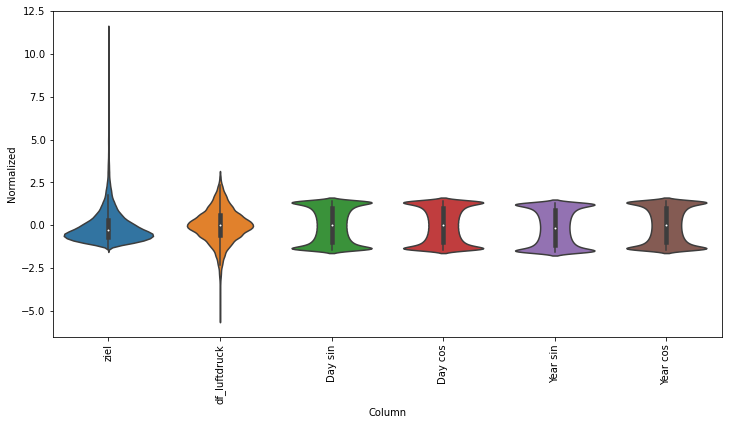

In [188]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

nur wenige starke Ausreisser

In [171]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ziel,87648.0,2.389844e+01,16.319040,0.842857,13.000000,1.964286e+01,30.057143,226.871429
df_luftdruck,87110.0,9.773227e+02,7.392501,936.500000,973.000000,9.774000e+02,981.800000,999.500000
Day sin,87648.0,3.240076e-16,0.707111,-1.000000,-0.707107,-1.122578e-14,0.707107,1.000000
Day cos,87648.0,-4.081863e-16,0.707111,-1.000000,-0.707107,-4.979055e-16,0.707107,1.000000
Year sin,87648.0,1.668304e-08,0.707152,-1.000000,-0.707175,1.791956e-05,0.707150,1.000000
Year cos,87648.0,-1.163745e-04,0.707070,-1.000000,-0.707161,-1.756117e-04,0.706903,1.000000
Wx,80479.0,9.247267e-01,2.236407,-11.093238,-0.629320,5.877853e-01,2.409152,10.031811
Wy,80479.0,-5.353700e-01,1.912392,-14.200000,-1.838478,-3.993178e-01,0.671031,11.741388
niederschlag,87098.0,4.042446e-02,0.350148,0.000000,0.000000,0.000000e+00,0.000000,26.820000


## Data windowing

Um Modelle mit unterschiedlichen Inputs (feature anzahl und sample anzahl) und Outputs (Vorhersagen für einen einzelnen Zeitpunkt oder Verläufe) erstellen zu können, muss man lediglich unterschiedliche Datenfenster erzeugen.


Die Klasse `WindowGenerator` kann aus input länge, offset und output länge ein Datenfenster erzeugen, mit dem das gewünschte Modell trainiert werden kann.

Sie generiert Beispielfenster und kann diese gemeinsam mit oder ohne den Vorhersagen eines Modells in einem Plot darstellen.

In [204]:
class WindowGenerator():
    
  @property
  def train(self):
    return self.make_dataset(self.train_df)
  
  @property
  def val(self):
    return self.make_dataset(self.val_df)
  
  @property
  def test(self):
    return self.make_dataset(self.test_df)
  
  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result

  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)
  
    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
  
    return inputs, labels

  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=512,)
  
    ds = ds.map(self.split_window)
  
    return ds

  def plot(self, model=None, plot_col='ziel', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(3, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
               label='Inputs', marker='.', zorder=-10)
  
      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index
  
      if label_col_index is None:
        continue
  
      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)
  
      if n == 0:
        plt.legend()
  
    plt.xlabel('Time [h]')


## Plot train vs. val

Um den Verlauf des Trainings bewerten zu können (Überanpassung, etc.)

In [88]:
def plot_train_val(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss)+1)
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Verlust Training')
    plt.plot(epochs, val_loss, 'b', label='Verlust Validierung')
    plt.title('Wert der Verlustfunktion Training/Validierung')
    plt.legend()
    plt.show()

## Funktion zum trainieren der Modelle
Mit Callback: Training hört bei Überanpassung oder nicht-konvergieren automatisch früher auf

In [89]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

# Modelle

## Modell zur Vorhersage von einem einzelnen Wert innerhalb 24h

Für dieses Modell wird ein Fenster erzeugt, dessen input-feature-vektor die Werte aller features für 24h enthält und dessen label (output) bis zu 24h in der Zukunft liegt und nur den pm10 durchschnitt enthält.

Vorhersage ist damit der vermutete durchschnittliche pm10 Wert von Graz.

In [205]:
single_step_window_6h = WindowGenerator(
    input_width=48, label_width=1, shift=12,
    label_columns=['ziel'])

single_step_window_24h = WindowGenerator(
    input_width=48, label_width=1, shift=48,
    label_columns=['ziel'])

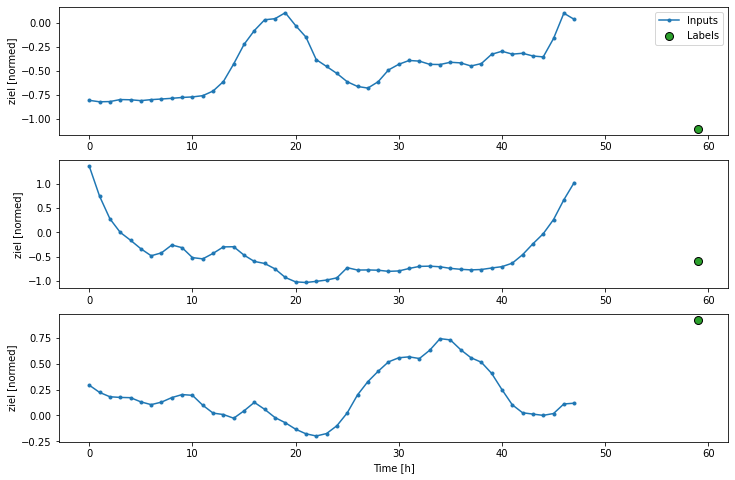

In [190]:
single_step_window_6h.plot()

Kleinere und größere Modelle, jeweils mit mehr oder weniger features wurden getestet, ohne deutliche Unterschiede in der Vorhersage

In [191]:
val_performance = {}

In [209]:
single_step_lstm = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, recurrent_dropout = 0.2, dropout=0.2),
    tf.keras.layers.LSTM(32, return_sequences=False, recurrent_dropout = 0.2, dropout=0.2),
    tf.keras.layers.Dense(units=1)
])

In [210]:
history_6h = compile_and_fit(single_step_lstm, single_step_window_6h, patience=5)

IPython.display.clear_output()
val_performance['single_step_lstm_6h_moreFeatures'] = single_step_lstm.evaluate(single_step_window_6h.val)

35/35 [==============================] - 1s 33ms/step - loss: 0.2586 - mean_absolute_error: 0.3486


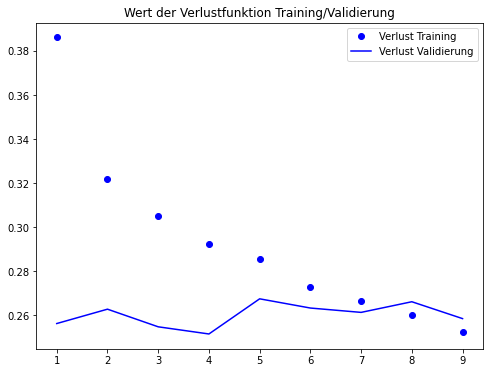

In [213]:
plot_train_val(history_6h)

Modell speichern -> dieses wird aktuell im Projekt verwendet

In [211]:
single_step_lstm.save('/home/pmf/MachineLearning/projects/Models/lstm_model_6h')

INFO:tensorflow:Assets written to: /home/pmf/MachineLearning/projects/Models/lstm_model_6h/assets


In [194]:
history_24h = compile_and_fit(single_step_lstm, single_step_window_24h, patience=5)

IPython.display.clear_output()
val_performance['single_step_lstm_24h_moreFeatures'] = single_step_lstm.evaluate(single_step_window_24h.val)

35/35 [==============================] - 1s 33ms/step - loss: 0.4869 - mean_absolute_error: 0.4860


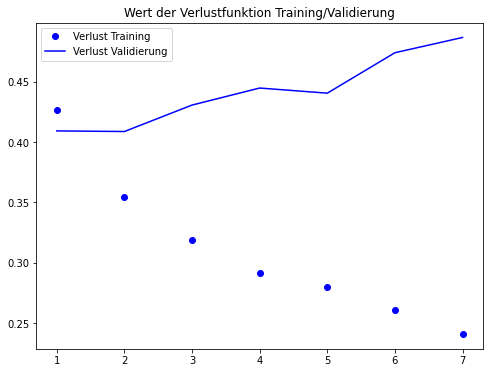

In [212]:
plot_train_val(history_24h)

In [214]:
for name, value in val_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

single_step_lstm_6h_moreFeatures: 0.3486
single_step_lstm_24h_moreFeatures: 0.4860


## Modell zur Vorhersage eines Verlaufs für die nächsten 24h

Wenn das Label eine Länge von 48 hat, wird ein Verlauf für die nächsten 24h vorhergesagt. Dieser Ansatz funktioniert natürlich noch schlechter, weil tatsächlich ein Muster für lange Verläufe erlernt werden muss.

Ein Feedback Modell, welches immer nur den nächsten Wert vorhersagt und diesen dann wieder in die Vorhersage des nächsten einbezieht wäre vermutlich präziser.


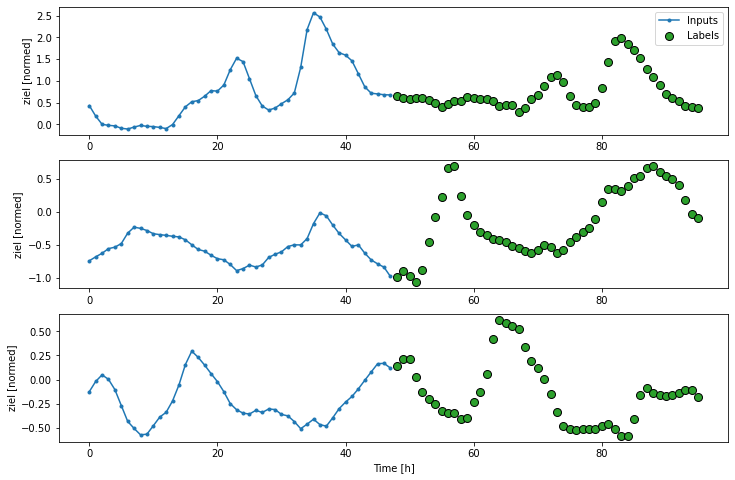

In [135]:
multi_window_24h = WindowGenerator(input_width=48,
                               label_width=48,
                               shift=48)

multi_window_24h.plot()

In [136]:
multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, recurrent_dropout = 0.2, dropout=0.2),
    tf.keras.layers.LSTM(32, return_sequences=False, recurrent_dropout = 0.2, dropout=0.2),
    tf.keras.layers.Dense(48,
                          kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([48, 1])
])

multi_step_rnn_history = compile_and_fit(multi_lstm_model, multi_window_24h)

IPython.display.clear_output()


35/35 [==============================] - 1s 34ms/step - loss: 0.8652 - mean_absolute_error: 0.7718


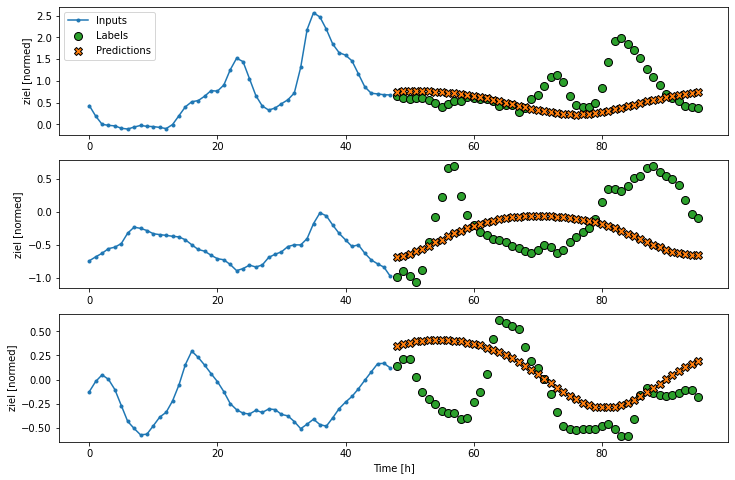

In [137]:
val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window_24h.val)
multi_window_24h.plot(multi_lstm_model)

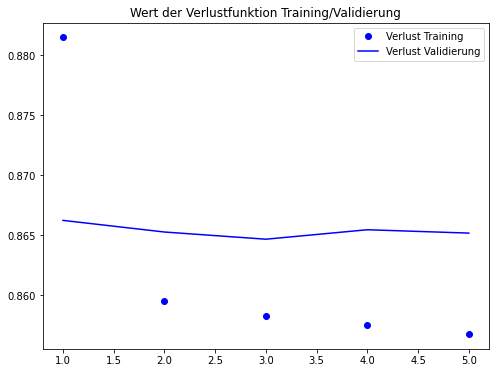

In [138]:
plot_train_val(multi_step_rnn_history)